In [3]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier

In [11]:
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt

In [177]:
from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    cross_validate, 
    StratifiedKFold
)
from sklearn.metrics import make_scorer, roc_auc_score
import optuna

# Helper functions

### Pipeline

In [44]:
class Transformer:
    def __init__(self, fn, *args, **kwargs):
        self.fn = fn
        self.args = args
        self.kwargs = kwargs
    
    def apply(self, x):
        return self.fn(x, *self.args, **self.kwargs)

class TransformerPipeline:
    def __init__(self, stages):
        self.stages = stages
    
    def apply(self, x):
        res = x
        for stage in self.stages:
            res = stage.apply(res)
        return res

### Pandas

In [39]:
def pd_withcolumn(df, col, vals):
    new_df = df.copy()
    new_df[col] = vals
    return new_df

### Plotting

In [17]:
def plot_kde_for_binary_clf(X, y, n_cols, figsize):
    feats = list(X.columns)
    n_rows = int(np.ceil(len(feats) / n_cols))
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=figsize, squeeze=True)
    fig.suptitle('KDE for features', fontsize=16)
    for (i, col) in enumerate(feats):
        ax = axs[i // n_cols][i % n_cols]
        ax.set_title(col)
        X[col][y==0].plot.kde(label='Class 0', ax=ax)
        X[col][y==1].plot.kde(label='Class 1', ax=ax)
        ax.legend()

In [21]:
def plot_hist_for_binary_clf(X, y, n_cols, figsize):
    feats = list(X.columns)
    n_rows = int(np.ceil(len(feats) / n_cols))
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=figsize, squeeze=True)
    for (i, col) in enumerate(feats):
        d = np.diff(np.unique(X[col])).min()
        l = X[col].min() - float(d)/2
        r = X[col].max() + float(d)/2
        ax = axs[i // n_cols][i % n_cols]
        ax.set_title(col)
        ax.hist(X.loc[y==0, col], bins=np.arange(l, r + d, d), alpha=0.5, density=True, label='Class 0')
        ax.hist(X.loc[y==1, col], bins=np.arange(l, r + d, d), alpha=0.5, density=True, label='Class 1')
        ax.legend()

# Load and explore data

In [29]:
df_full = pd.read_csv('./data/train.csv')

In [30]:
df_full.shape

(70000, 13)

In [31]:
df_full.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [32]:
df_full['cardio'].mean()

0.4997

In [33]:
df_full.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
(df_full['age'] / 365.5).describe()

count    70000.000000
mean        53.266391
std          6.750347
min         29.543092
25%         48.328317
50%         53.906977
75%         58.350205
max         64.878249
Name: age, dtype: float64

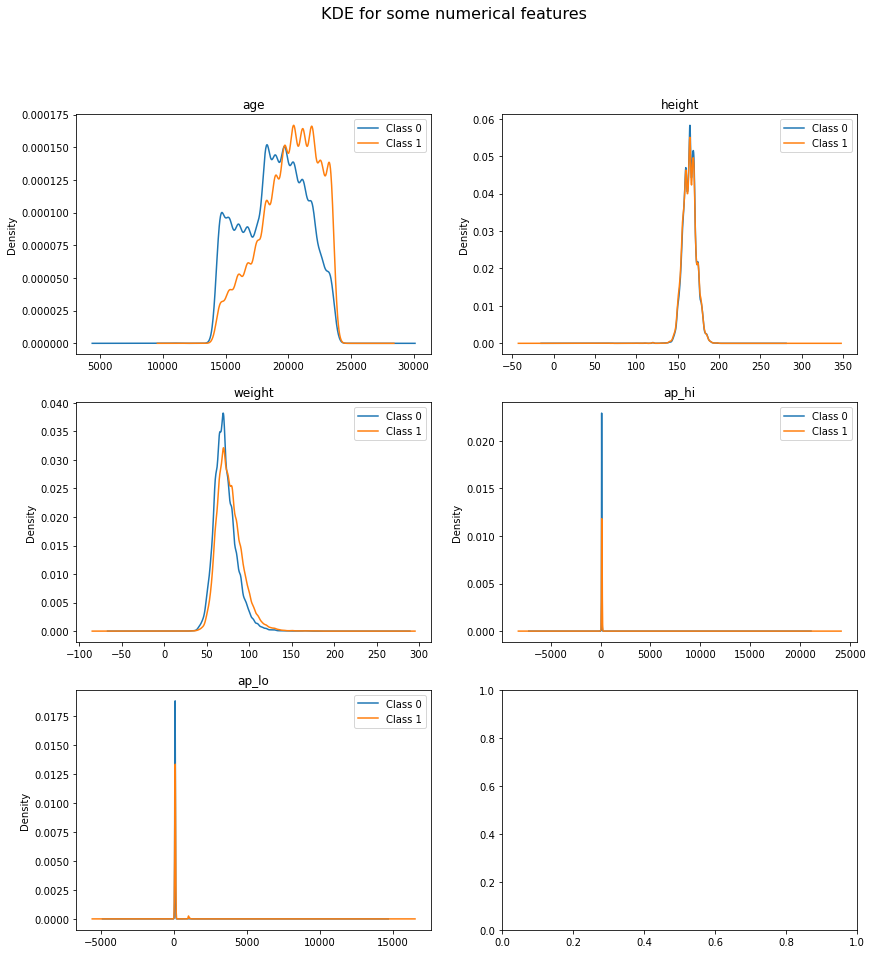

In [16]:
plot_kde_for_binary_clf(
    X=df_full[['age', 'height', 'weight', 'ap_hi', 'ap_lo']], 
    y=df_full['cardio'], 
    n_cols=2, 
    figsize=(14, 15)
)

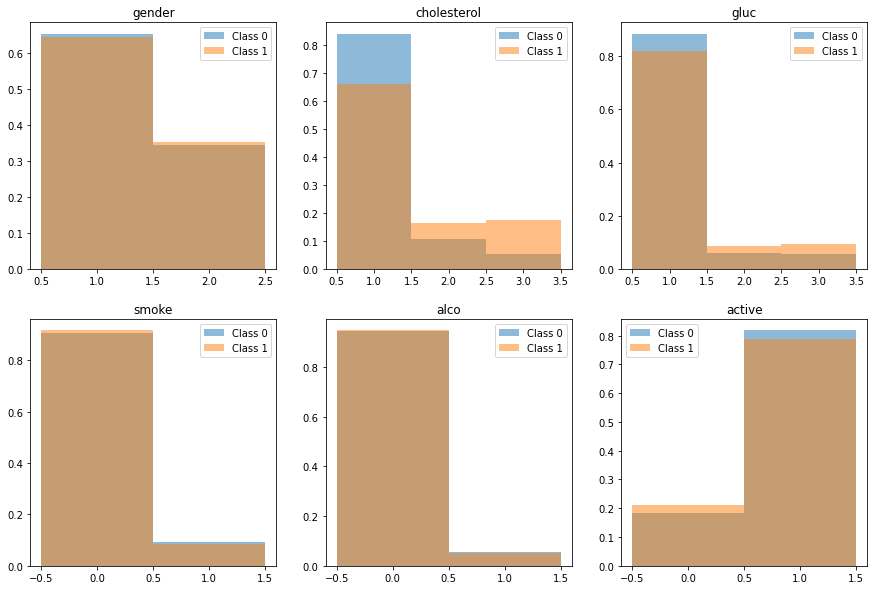

In [22]:
plot_hist_for_binary_clf(
    df_full[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']],
    df_full['cardio'],
    n_cols=3,
    figsize=(15,10)
)

# Split data

In [35]:
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state=42, stratify=df_full['cardio'])

In [37]:
for name, df in zip(['train', 'test'], [df_train, df_test]):
    print(name)
    print(len(df), df['cardio'].mean())

train
52500 0.4996952380952381
test
17500 0.4997142857142857


# Define data preparation pipelines

In [84]:
pipeline_incorrect_vals = TransformerPipeline(
    [
        Transformer(lambda df: pd_withcolumn(df, 'ap_hi', 
            df['ap_hi'].apply(lambda x: x if ((x > 50) and (x < 250)) else np.nan))),
        Transformer(lambda df: pd_withcolumn(df, 'ap_lo', 
            df['ap_lo'].apply(lambda x: x if ((x > 50) and (x < 250)) else np.nan))),
    ]
)

In [57]:
pipeline_feats = TransformerPipeline(
    [
        Transformer(lambda df: df.drop('id', axis=1)),
        Transformer(lambda df: pd_withcolumn(df, 'body_mass_index', df['weight'] / df['height']**2 * 1e4)),
        Transformer(lambda df: pd_withcolumn(df, 'ap_spread', df['ap_hi'] - df['ap_lo'])),
        Transformer(lambda df: pd_withcolumn(df, 'ap_mean', 0.5 * (df['ap_hi'] + df['ap_lo']))),
    ]
)

In [88]:
tr_split_xy = Transformer(lambda df: (df.drop('cardio', axis=1), df['cardio']))

In [89]:
pipeline_full_train = TransformerPipeline(
    [
        pipeline_incorrect_vals,
        pipeline_feats,
        tr_split_xy
    ]
)

In [93]:
pipeline_full_test = TransformerPipeline(
    [
        pipeline_feats,
        tr_split_xy
    ]
)

# Prepare train/test datasets

In [94]:
X_train, y_train = pipeline_full_train.apply(df_train)

In [181]:
X_test, y_test = pipeline_full_test.apply(df_test)

# Try to fit some model

In [182]:
clf = LGBMClassifier()

In [183]:
cv_results = cross_validate(clf, X_train, y_train, 
    cv=StratifiedKFold(10, shuffle=True, random_state=42),
    scoring=make_scorer(roc_auc_score, needs_proba=True), # (!) needs_proba=True is crucial here
    return_train_score=True, 
    n_jobs=-1)

In [184]:
cv_results

{'fit_time': array([0.56283903, 0.62084842, 0.59784532, 0.62484908, 0.60184717,
        0.52983737, 0.57784176, 0.56883812, 0.5478251 , 0.57683444]),
 'score_time': array([0.03200579, 0.03400731, 0.03000474, 0.03000665, 0.0370059 ,
        0.03300118, 0.02600384, 0.02900481, 0.02700424, 0.037009  ]),
 'test_score': array([0.80690616, 0.80583971, 0.8140767 , 0.79552322, 0.8032157 ,
        0.80536188, 0.79533022, 0.79236256, 0.80708968, 0.79938457]),
 'train_score': array([0.8292911 , 0.82903475, 0.82856476, 0.83085097, 0.8292863 ,
        0.82937615, 0.83031745, 0.83124838, 0.82970213, 0.82993841])}

In [185]:
clf.fit(X_train, y_train)

LGBMClassifier()

In [186]:
pred_test = clf.predict_proba(X_test)[:, 1]

In [187]:
roc_auc_score(y_test, pred_test)

0.7993044242626691

# Hyperopt

In [178]:
def aggregate_cv_scores(train_scores, test_scores, std_coef=1.0, overfit_coef=1.0):
    # Suppose that scores are positive; the higher the score the better
    return (
        test_scores.mean()
        - std_coef * test_scores.std()
        - overfit_coef * ((train_scores > test_scores) * (train_scores - test_scores)).mean()
    )

In [201]:
def init_clf(**params):
    default_params = {
        'subsample_freq': 10,
        'random_state': 42,
    }
    initialization_params = {**default_params, **params}
    return LGBMClassifier(**initialization_params)

In [215]:
def construct_objective(X, y):
    def _objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 10, 250, 2),
            # max_depth is not restricted
            'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_uniform('subsample', 0.3, 0.7),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e3),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e3),
        }
        clf = init_clf(**params)
        cv_results = cross_validate(clf, X, y, 
            cv=StratifiedKFold(10, shuffle=True, random_state=42),
            scoring=make_scorer(roc_auc_score, needs_proba=True),
            return_train_score=True, 
            n_jobs=-1)
        final_score = aggregate_cv_scores(
            cv_results['train_score'], 
            cv_results['test_score'],
            std_coef=0.5, overfit_coef=0.5
        )
        return final_score
    return _objective

hyperopt_objective = construct_objective(X_train, y_train)

In [216]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(hyperopt_objective, n_trials=200)

[I 2022-02-05 17:27:09,973] A new study created in memory with name: no-name-f3f465eb-e197-47f9-9d81-b4c2c3be8c9a
[I 2022-02-05 17:27:25,088] Trial 0 finished with value: 0.6511560908356686 and parameters: {'num_leaves': 100, 'n_estimators': 480, 'learning_rate': 0.22227824312530747, 'subsample': 0.5394633936788146, 'colsample_bytree': 0.46240745617697465, 'reg_alpha': 0.008629132190071854, 'reg_lambda': 0.002231010801867922}. Best is trial 0 with value: 0.6511560908356686.
[I 2022-02-05 17:27:27,132] Trial 1 finished with value: 0.7916866128752431 and parameters: {'num_leaves': 218, 'n_estimators': 310, 'learning_rate': 0.21534104756085318, 'subsample': 0.308233797718321, 'colsample_bytree': 0.7879639408647978, 'reg_alpha': 98.77700294007911, 'reg_lambda': 0.018794668241638456}. Best is trial 1 with value: 0.7916866128752431.
[I 2022-02-05 17:27:28,849] Trial 2 finished with value: 0.7813832917767968 and parameters: {'num_leaves': 54, 'n_estimators': 100, 'learning_rate': 0.0982302504

[I 2022-02-05 17:29:15,881] Trial 22 finished with value: 0.7956400195462606 and parameters: {'num_leaves': 76, 'n_estimators': 100, 'learning_rate': 0.1555296677867104, 'subsample': 0.3438836331568572, 'colsample_bytree': 0.6051626284280756, 'reg_alpha': 0.0023417096414590994, 'reg_lambda': 905.8079013337925}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:29:17,301] Trial 23 finished with value: 0.7871787581487079 and parameters: {'num_leaves': 68, 'n_estimators': 80, 'learning_rate': 0.12919234638566787, 'subsample': 0.3266856235198263, 'colsample_bytree': 0.6093132030289645, 'reg_alpha': 0.0012370584890094682, 'reg_lambda': 46.26066322915486}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:29:17,994] Trial 24 finished with value: 0.795424360851909 and parameters: {'num_leaves': 10, 'n_estimators': 50, 'learning_rate': 0.10497710694853352, 'subsample': 0.4161272506268608, 'colsample_bytree': 0.5003255566539667, 'reg_alpha': 0.027661681068456984,

[I 2022-02-05 17:29:49,271] Trial 44 finished with value: 0.795544601027386 and parameters: {'num_leaves': 22, 'n_estimators': 100, 'learning_rate': 0.13337267055738242, 'subsample': 0.36293133261584776, 'colsample_bytree': 0.42846001477147344, 'reg_alpha': 0.11935375225350571, 'reg_lambda': 523.3880997462667}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:29:50,111] Trial 45 finished with value: 0.7937180287273814 and parameters: {'num_leaves': 36, 'n_estimators': 30, 'learning_rate': 0.09489802646511025, 'subsample': 0.3911927483470115, 'colsample_bytree': 0.5458967562639049, 'reg_alpha': 0.21155115069253236, 'reg_lambda': 93.50709128508933}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:29:52,533] Trial 46 finished with value: 0.7800084356612547 and parameters: {'num_leaves': 52, 'n_estimators': 150, 'learning_rate': 0.1147708047783764, 'subsample': 0.4482508832971738, 'colsample_bytree': 0.401730808591127, 'reg_alpha': 1.0519626708737235, 're

[I 2022-02-05 17:30:28,984] Trial 66 finished with value: 0.7907063794436746 and parameters: {'num_leaves': 24, 'n_estimators': 150, 'learning_rate': 0.22516634896757037, 'subsample': 0.47526196340951005, 'colsample_bytree': 0.5803176005869073, 'reg_alpha': 0.021882245920596437, 'reg_lambda': 310.0947148885508}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:30:31,783] Trial 67 finished with value: 0.7535364847106392 and parameters: {'num_leaves': 32, 'n_estimators': 230, 'learning_rate': 0.18811969822176264, 'subsample': 0.5202676984338529, 'colsample_bytree': 0.5332985486273563, 'reg_alpha': 0.010426806508613716, 'reg_lambda': 0.08029432864433438}. Best is trial 12 with value: 0.7966831610403304.
[I 2022-02-05 17:30:32,558] Trial 68 finished with value: 0.7915622814352897 and parameters: {'num_leaves': 44, 'n_estimators': 40, 'learning_rate': 0.138258078219901, 'subsample': 0.5746655148027864, 'colsample_bytree': 0.5002380059484528, 'reg_alpha': 0.08195221718887849

[I 2022-02-05 17:31:20,319] Trial 88 finished with value: 0.7829678275370655 and parameters: {'num_leaves': 36, 'n_estimators': 270, 'learning_rate': 0.23644368738292737, 'subsample': 0.631504545201373, 'colsample_bytree': 0.5378940287130188, 'reg_alpha': 1.2399890716148265, 'reg_lambda': 377.83729244352645}. Best is trial 74 with value: 0.7968792884644595.
[I 2022-02-05 17:31:22,881] Trial 89 finished with value: 0.7873589662462256 and parameters: {'num_leaves': 30, 'n_estimators': 180, 'learning_rate': 0.1576444138803281, 'subsample': 0.6565875603664374, 'colsample_bytree': 0.47281320167333807, 'reg_alpha': 0.4213767311681673, 'reg_lambda': 137.48214156194433}. Best is trial 74 with value: 0.7968792884644595.
[I 2022-02-05 17:31:24,975] Trial 90 finished with value: 0.7885022580548858 and parameters: {'num_leaves': 10, 'n_estimators': 240, 'learning_rate': 0.177994245218141, 'subsample': 0.6775054119189885, 'colsample_bytree': 0.5188069401007112, 'reg_alpha': 1.8801093489957803, 'reg

[I 2022-02-05 17:32:06,873] Trial 110 finished with value: 0.7940360536301364 and parameters: {'num_leaves': 28, 'n_estimators': 130, 'learning_rate': 0.21099269467067538, 'subsample': 0.5450693689881415, 'colsample_bytree': 0.6184675737138231, 'reg_alpha': 1.36092501014026, 'reg_lambda': 569.1067867530995}. Best is trial 100 with value: 0.7969803516917086.
[I 2022-02-05 17:32:08,750] Trial 111 finished with value: 0.7962976893904253 and parameters: {'num_leaves': 10, 'n_estimators': 180, 'learning_rate': 0.23332760685826004, 'subsample': 0.5673233515684252, 'colsample_bytree': 0.5717148532563561, 'reg_alpha': 0.4779831741479201, 'reg_lambda': 990.7172245098957}. Best is trial 100 with value: 0.7969803516917086.
[I 2022-02-05 17:32:10,632] Trial 112 finished with value: 0.7968590108175136 and parameters: {'num_leaves': 10, 'n_estimators': 150, 'learning_rate': 0.1946379767010888, 'subsample': 0.6054916537726447, 'colsample_bytree': 0.5504378454282403, 'reg_alpha': 0.3108561534659568, '

[I 2022-02-05 17:32:51,608] Trial 132 finished with value: 0.7970199153394854 and parameters: {'num_leaves': 10, 'n_estimators': 130, 'learning_rate': 0.1619792302618955, 'subsample': 0.6029996583929464, 'colsample_bytree': 0.557689261292493, 'reg_alpha': 0.001745381190612698, 'reg_lambda': 440.8029967627296}. Best is trial 132 with value: 0.7970199153394854.
[I 2022-02-05 17:32:53,118] Trial 133 finished with value: 0.7969092436362918 and parameters: {'num_leaves': 10, 'n_estimators': 120, 'learning_rate': 0.16258690136871795, 'subsample': 0.605533694617456, 'colsample_bytree': 0.5508619159997021, 'reg_alpha': 0.28215949810814134, 'reg_lambda': 432.10808877411654}. Best is trial 132 with value: 0.7970199153394854.
[I 2022-02-05 17:32:54,561] Trial 134 finished with value: 0.796975844156207 and parameters: {'num_leaves': 10, 'n_estimators': 120, 'learning_rate': 0.16278688120737775, 'subsample': 0.6055522329230473, 'colsample_bytree': 0.5516942130147093, 'reg_alpha': 0.0014026620639305

[I 2022-02-05 17:33:24,904] Trial 154 finished with value: 0.7952390586959525 and parameters: {'num_leaves': 22, 'n_estimators': 120, 'learning_rate': 0.1674260137886251, 'subsample': 0.5973696408073473, 'colsample_bytree': 0.6412512108764414, 'reg_alpha': 0.005050885566263999, 'reg_lambda': 659.4157241397513}. Best is trial 143 with value: 0.7970647675505321.
[I 2022-02-05 17:33:26,333] Trial 155 finished with value: 0.796817749159719 and parameters: {'num_leaves': 10, 'n_estimators': 110, 'learning_rate': 0.14675773298828268, 'subsample': 0.5883805709650983, 'colsample_bytree': 0.6181703262364258, 'reg_alpha': 0.011135663738784085, 'reg_lambda': 321.14076506665737}. Best is trial 143 with value: 0.7970647675505321.
[I 2022-02-05 17:33:27,250] Trial 156 finished with value: 0.7965811929378522 and parameters: {'num_leaves': 14, 'n_estimators': 60, 'learning_rate': 0.16034134713523882, 'subsample': 0.5780446954134194, 'colsample_bytree': 0.6590079960057308, 'reg_alpha': 0.01919031866273

[I 2022-02-05 17:33:57,703] Trial 176 finished with value: 0.7968383243374553 and parameters: {'num_leaves': 10, 'n_estimators': 100, 'learning_rate': 0.14456851863366618, 'subsample': 0.5802051209114873, 'colsample_bytree': 0.6254981759873137, 'reg_alpha': 0.00782351620663787, 'reg_lambda': 478.5915867400776}. Best is trial 172 with value: 0.7973613172207283.
[I 2022-02-05 17:33:59,307] Trial 177 finished with value: 0.7953911741856774 and parameters: {'num_leaves': 18, 'n_estimators': 100, 'learning_rate': 0.14293580202886788, 'subsample': 0.5651656988515592, 'colsample_bytree': 0.626767481735571, 'reg_alpha': 0.008067368433736, 'reg_lambda': 274.282573719375}. Best is trial 172 with value: 0.7973613172207283.
[I 2022-02-05 17:34:00,402] Trial 178 finished with value: 0.7975222279991833 and parameters: {'num_leaves': 10, 'n_estimators': 70, 'learning_rate': 0.12705135017897037, 'subsample': 0.5537182612651214, 'colsample_bytree': 0.6172950925125946, 'reg_alpha': 0.0055279478534313534

[I 2022-02-05 17:34:22,151] Trial 198 finished with value: 0.795108741633382 and parameters: {'num_leaves': 20, 'n_estimators': 70, 'learning_rate': 0.13468003595476788, 'subsample': 0.5633675178210479, 'colsample_bytree': 0.6054762733334642, 'reg_alpha': 0.012318073078140994, 'reg_lambda': 55.576165511244916}. Best is trial 178 with value: 0.7975222279991833.
[I 2022-02-05 17:34:23,297] Trial 199 finished with value: 0.7974424787400252 and parameters: {'num_leaves': 10, 'n_estimators': 70, 'learning_rate': 0.13632981526803228, 'subsample': 0.6002669436274147, 'colsample_bytree': 0.6211003388064682, 'reg_alpha': 0.021783021226793094, 'reg_lambda': 166.4777832399227}. Best is trial 178 with value: 0.7975222279991833.


In [217]:
clf_final = init_clf(**study.best_trial.params)

In [218]:
clf_final

LGBMClassifier(colsample_bytree=0.6172950925125946,
               learning_rate=0.12705135017897037, n_estimators=70,
               num_leaves=10, random_state=42, reg_alpha=0.0055279478534313534,
               reg_lambda=139.5031787266367, subsample=0.5537182612651214,
               subsample_freq=10)

In [219]:
cv_results = cross_validate(clf_final, X_train, y_train, 
    cv=StratifiedKFold(10, shuffle=True, random_state=42),
    scoring=make_scorer(roc_auc_score, needs_proba=True), # (!) needs_proba=True is crucial here
    return_train_score=True, 
    n_jobs=-1)
cv_results

{'fit_time': array([0.45687652, 0.41079926, 0.43187118, 0.42687678, 0.40379596,
        0.41486883, 0.41987038, 0.42386818, 0.43586802, 0.44187284]),
 'score_time': array([0.01900291, 0.01900387, 0.02600455, 0.02100158, 0.02607656,
        0.02000451, 0.02600336, 0.02600551, 0.02700567, 0.02700543]),
 'test_score': array([0.80571853, 0.80659893, 0.81440845, 0.79693456, 0.80425872,
        0.8070364 , 0.79622433, 0.79342016, 0.80443346, 0.80072538]),
 'train_score': array([0.80696913, 0.80646585, 0.80583217, 0.80744384, 0.80700856,
        0.80605807, 0.80792608, 0.80813505, 0.80674645, 0.80739276])}

In [220]:
clf_final.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6172950925125946,
               learning_rate=0.12705135017897037, n_estimators=70,
               num_leaves=10, random_state=42, reg_alpha=0.0055279478534313534,
               reg_lambda=139.5031787266367, subsample=0.5537182612651214,
               subsample_freq=10)

In [221]:
roc_auc_score(y_test, clf_final.predict_proba(X_test)[:, 1])

0.7991952715739662